# SMS Spam Classifier

[Prashant Brahmbhatt](prashantbrahmbhatt.bio.link)

#### Let's import some libraries

In [287]:
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Loading the data

In [288]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',names = ['Label','Message'])

#### Let's take a look at the sample examples in the data

In [439]:
sample_data = messages.sample(5) 
[print(label, message, '\n') for label, message in zip(sample_data['Label'],sample_data['Message'])]

ham K...k:)why cant you come here and search job:) 

ham Get the door, I'm here 

spam +449071512431 URGENT! This is the 2nd attempt to contact U!U have WON £1250 CALL 09071512433 b4 050703 T&CsBCM4235WC1N3XX. callcost 150ppm mobilesvary. max£7. 50 

spam I want some cock! My hubby's away, I need a real man 2 satisfy me. Txt WIFE to 89938 for no strings action. (Txt STOP 2 end, txt rec £1.50ea. OTBox 731 LA1 7WS. ) 

ham Not directly behind... Abt 4 rows behind ü... 



[None, None, None, None, None]

As we can see the data looks so messy. We're going to need some cleaning.

In [290]:
messages.sample(5)

,Label,Message
2409,ham,Dear where you will be when i reach there
2569,ham,Hey. For me there is no leave on friday. Wait ...
3436,ham,Hi darlin i cantdo anythingtomorrow as myparen...
57,ham,"Sorry, I'll call later in meeting."
3696,ham,"Hello, As per request from &lt;#&gt; Rs.5 ha..."


In [291]:
n = 211 #np.random.randint(len(messages))
sample_message = messages['Message'][n]
sample_message

"What's up bruv, hope you had a great break. Do have a rewarding semester."

#### We should convert our text to lower case. So words like `"And"` and `"aNd"` are not different

In [292]:
sample_message = sample_message.lower()
sample_message

"what's up bruv, hope you had a great break. do have a rewarding semester."

#### Removing Punctuations

In [293]:
sample_message = "".join([char for char in sample_message if char not in string.punctuation])
sample_message

'whats up bruv hope you had a great break do have a rewarding semester'

#### Removing the Stopwords

In [442]:
stopwords.words('english')[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [294]:
sample_message = " ".join([word for word in sample_message.split(' ') if word not in stopwords.words('english')])
sample_message

'whats bruv hope great break rewarding semester'

In [295]:
from nltk.corpus import stopwords

In [364]:
def text_process(mess):
    '''
    Converting to lowercase
    Removing the punctuations
    Removing the common words 
    Returning the cleaned words
    '''
    mess = mess.lower()
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    nostop = [word for word in nopunc.split() if word not in stopwords.words('english')]
    nostop = ' '.join(nostop)
    return nostop

Let's apply the entire process function of the data

In [365]:
cleaned_messages = messages['Message'].apply(text_process)

In [366]:
cleaned_messages[:5]

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                  u dun say early hor u c already say
4          nah dont think goes usf lives around though
Name: Message, dtype: object

#### Count Vectorization

In [369]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer()
# bow_transformer.fit(messages['Message'])
bow_transformer.fit(cleaned_messages)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

We can see the entire vocabulary. Let's just see 10 words for now.

In [370]:
vocabulary = bow_transformer.get_feature_names()
print('Length of Vocabulary:', len(vocabulary))

Length of Vocabulary: 9437


In [381]:
vocabulary[1800:1810]

['bras',
 'brats',
 'braved',
 'bray',
 'brb',
 'brdget',
 'bread',
 'breadstick',
 'break',
 'breaker']

In [372]:
sample_message_bow = bow_transformer.transform([sample_message]).toarray()

We know in our sentence there should be 1s at 7 places for 7 words and we can confirm that

In [373]:
print('Cleaned Message: ',sample_message)
print('Count Vectorized Message: ',sample_message_bow)
print('Length of Vectorized Message: ',len(sample_message_bow[0]))
print('Total words in Vectorized Message', sample_message_bow.sum())

Cleaned Message:  whats bruv hope great break rewarding semester
Count Vectorized Message:  [[0 0 0 ... 0 0 0]]
Length of Vectorized Message:  9437
Total words in Vectorized Message 7


As we can see in the above vocabulary 'break' is at 1808 index, at the same position there should be 1 in the vectorized message.

In [378]:
sample_message_bow[0][1800:1810]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

As expected! 
Now let's transform the whole corpus

In [382]:
bow_messages = bow_transformer.transform(cleaned_messages)

In [383]:
print('Shape of Sparse Matrix: ',bow_messages.shape)
print('Number of Non-Zeros: ',bow_messages.nnz)

Shape of Sparse Matrix:  (5572, 9437)
Number of Non-Zeros:  47493


In [384]:
sparsity = (100 * bow_messages.nnz)/(bow_messages.shape[0] * bow_messages.shape[1])
print('Sparsity: ',sparsity)

Sparsity:  0.09032012725642473


#### Splitting the Data

We will split the data into Training set and testing set.  
The testing set will not be seen by the model and we will get an accurate measure of how good it is performing.

In [385]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bow_messages, messages['Label'], test_size = 0.25, random_state = 101)

#### Training the Model

We will use a Multinomial Naive Bayes as our classification model.  
You can experiment with more of them.

In [386]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB()
spam_detect_model = spam_detect_model.fit(x_train, y_train)

Let's make predictions on the unseen test set

In [387]:
predictions = spam_detect_model.predict(x_test)

In [388]:
from sklearn.metrics import classification_report, confusion_matrix
cfr = classification_report(y_test, predictions)
print(cfr)

              precision    recall  f1-score   support

         ham       0.99      0.98      0.98      1227
        spam       0.86      0.92      0.89       166

    accuracy                           0.97      1393
   macro avg       0.93      0.95      0.94      1393
weighted avg       0.97      0.97      0.97      1393



In [389]:
import matplotlib.pyplot as plt
import seaborn as sns

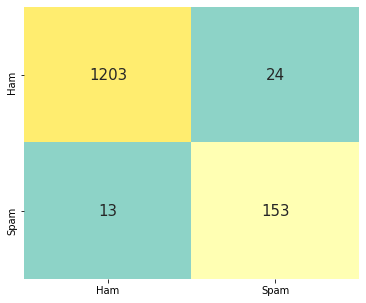

In [390]:
plt.figure(figsize = (6,5))
f = sns.heatmap(confusion_matrix(y_test, predictions), annot = True, cmap = 'Set3', fmt='g', cbar = False, annot_kws={"fontsize":15})
plt.xticks(f.get_xticks(), labels=['Ham', 'Spam'])
plt.yticks(f.get_xticks(), labels=['Ham', 'Spam']);

If you know how to interpret confusion matrix, from the test set  
we are marking 24 out of 1227 as spam which are not spam and  
13 out of 166 are spam that we have marked as not spam.

Let's check some samples and try to predict on them with this model.

In [404]:
def predict_user(input_message):
    processed_message = text_process(input_message)
    processed_message = bow_transformer.transform([processed_message])
    return spam_detect_model.predict(processed_message)[0]

In [403]:
input_message = "Woohoo! Congrats! You have won a lottery for $50 claim your prize now and call us at 9999-555-555"
predict_user(input_message)

'spam'

In [422]:
input_message = "never gonna give you up, never gonna let you down"
predict_user(input_message)

'ham'

In [424]:
input_message = "Here's your free ticket to the champions league final. Only you are the deserved winner, claim soon."
predict_user(input_message)

'spam'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=de114742-2655-4a7e-9b33-628102a2316a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0b86c8a6-6f0c-4783-a8a8-e7618f7772b9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>